# Continuous Control


### Introduction

Unity ML-agent library has a lot of simulation evnrionments to test intelligent agent models. 
This notebook solves one of the envrionnment with a task name called **Reacher**
The task is to move a 2-joint robot arm to a specific position. 
As the robot arm correctly follows the guided position, more points can be obtained.
In this notebook, the agent uses a Deep Deterministic Policy Gradient model (DDPG) to learn an intelligent behavior to meet the objective and the environment will have 20 agents and robot arms.
All the code is self contained in a notebook for a potential modification of any logic. 
Each component is separated to its own cell, so it can be easily written to a separate file using "%writefile" if necessary

---


### 1. Environment
#### Requirements
- Linux based OS
- Python (dependency is listed in requirements.txt)
- [Linux 20-arm Reacher environment](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P2/Reacher/Reacher_Linux.zip)

The following code will import modules and packages required to train and evaluate a Actor/Critic models with DDPG algorithm

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# Unzip the Reacher environment file and pass the path of "Reacher.x86_64" to UnityEnvironment as an argument
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

#### The environment spec
- Number of agent: 20
- State space: 33 dimensional vector (for each agent)
- Action space: 4 numbers of range [-1, 1]
- Reward: +0.1 (If the agent's arm is located at a guided location)

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 2. Implementation

#### ActorModel
- **Description**
    - Standard fully-connected NN with a Batchnorm layer and ReLU activation. This model is used to model the deterministic policy, so it outputs 4 continous action vectors.
- **Architecture**
    - 2 Hidden layers (128, 64 nodes)
    - 1 Output layer (4 nodes)
    - Each hidden layer uses ReLU and Batchnorm1d
    - Final output layer is a single linear layer with tanh activation to conform to the action value range
- **Discussion**
    - The initial hidden layer expanded the number of nodes for exploring rich feature space
    - ReLU and Batchnorm layer are used for stable training
    - Final output layer is combined with tanh to generate action of a correct range
 
#### CriticModel
- **Description**
    - A fully-connected NN which combines a state and action to generate Q value for a given state, action pair.
- **Architecture**
    - 2 Hidden layers (128, 128 nodes)
    - 1 Output layer (1 node)
    - Each hidden layer uses ReLU
    - State value is normalized by BatchNorm1d
    - Final output layer is a single linear layer without any activation function
- **Discussion**
    - To deal with different characteristics of state and action, they're embedded to the first hidden layer separately
        - The first hidden layer 128 nodes are divided with the ratio of state and action dimensions (33 to 4)
    - The initial hidden layer expanded the number of nodes for exploring rich feature space
    - The number of nodes are decided with experiments
    - Batchnorm layer is removed because it gives worse performance
    - Final output layer directly generates an action value
 

#### Buffer
- **Description**
    - Replay buffer used in a DDPG algorithm. It is a standard deque with a sampling function
- **Interface**
    - Initialization
        - sz: Replay buffer size
        - pf: Probability function for sampling
    - put(obj): Stored obj in a replay buffer
    - sample(n): Sample n objects from a replay buffer
    - update_pf(pf): Update the probability function pf
- **Discussion**
    - pf can be used for prioritized experience replay
    - It was used to explore the potential benefit of the skew in experience sampling, but was default to uniform sampling

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
class ActorModel(nn.Module):
    def __init__(self, nfs = [33, 128, 64, 4]):
        super().__init__()
        self.nfs = nfs
        
        dr = nn.Dropout()
        layers = [nn.BatchNorm1d(self.nfs[0])]
        for nif, nof in zip(self.nfs[:-2], self.nfs[1:-1]):
            layers.append(nn.Linear(nif, nof))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(nof))
#             layers.append(dr)
        
        self.layers = nn.Sequential(*layers)
        self.olin = nn.Linear(self.nfs[-2], self.nfs[-1])
    
    def forward(self, x):
        f = self.layers(x)
        actions = F.tanh(self.olin(f))
        
        return actions

In [8]:
class CriticModel(nn.Module):
    def __init__(self, nfs = [128, 128, 1], ns=33, na=4):
        super().__init__()
        self.nfs = nfs
        self.ns = ns
        self.na = na
        
        dr = nn.Dropout()
        
        num_state_fs = int(self.nfs[0] * self.ns /(self.ns+self.na))
        num_act_fs = self.nfs[0] - num_state_fs
        
        self.state_fs = nn.Sequential(
            nn.BatchNorm1d(self.ns), 
            nn.Linear(self.ns, num_state_fs),
            nn.ReLU()#,
#             nn.BatchNorm1d(num_state_fs)
        )
        self.act_fs = nn.Sequential(
            nn.Linear(self.na, num_act_fs),
            nn.ReLU()#,
#             nn.BatchNorm1d(num_act_fs)
        )
        
        layers = []
        for nif, nof in zip(self.nfs[:-2], self.nfs[1:-1]):
            layers.append(nn.Linear(nif, nof))
            layers.append(nn.ReLU())
#             layers.append(nn.BatchNorm1d(nof))
#             layers.append(dr)
        
        self.layers = nn.Sequential(*layers)
        self.olin = nn.Linear(self.nfs[-2], self.nfs[-1])
    
    def forward(self, x, a):
        xf = self.state_fs(x)
        af = self.act_fs(a)
        f = self.layers(torch.cat((xf, af), 1))
        values = self.olin(f)
        
        return values

In [9]:
class Buffer:
    def __init__(self, sz=50000, pf=70):# pf=lambda x: 1):
        self.buf = deque(maxlen=sz)
        self.px = deque(maxlen=sz)
        self.temp = []
        self.pf = pf
        
    def update_pf(self, pf=lambda x: 1):
        self.pf = pf
        
    def put(self, sars):
        self.temp.append(sars)
        if sars[2] != 0:
            self.buf.extend(self.temp)
            self.px.extend([self.pf(x) for x in range(-len(self.temp) + 1, 1)])
#             newbuf = self.temp[np.random.randint(self.pf//70):self.pf:int(self.pf//70)]
#             self.buf.extend(newbuf)
#             self.px.extend([1 for _ in range(len(newbuf))])
            self.temp.clear()
    
    def sample(self, n=64):
        bufsz = len(self.buf)
        assert bufsz == len(self.px)
        n = bufsz if bufsz <= n else n
        idxs = np.random.choice(range(bufsz), n, replace=False, p=(self.px / np.sum(self.px)))
        samples = [self.buf[i] for i in idxs]
        
        states, actions, rewards, nstates = zip(*samples)
        return states, actions, rewards, nstates
    
    def __len__(self):
        return len(self.buf)
    
    def clear(self):
        self.temp = []

#### Training
- **Description**
    - Standard DDPG training algorithm
- **Detail**
    1. Initialize the models(2 actors, 2 critics) and hyperparameters
    2. The current-actor-model (agent) interacts with the Reaper Unity environment to collect tuples (state, action, reward, next-state)
        2-a. Exploration in continuous space is implemented using a Gaussian noise. The noise's standard deviation is controlled by an epsilon parameter
        2-b. Due to the probabilistic nature of the noise, the action is clipped to range [-1, 1]
    3. The collected tuples (experiences) are stored in a replay buffer
    4. The experience is randomly batch-sampled every 20 steps("train_step") and used to train the NN model
        4-a. Due to the multi-agent nature of the environment, The single batch size is 512 and 10 successive gradient updates happen in a single training procedure.
        4-b. The training procedure follows a standard DDPG algorithm
            4-b1. Current-critic-model is trained with TD-update using Target-actor/critic-models
            4-b2. Current-actor model is trained with Q value using Target-critic-model
            4-b3. Target-actor/critic-models are soft-updated with current models using a small mixture ratio(tau)
    5. 2-4 are repeated until the average score(return) reaches the objective score (13)
- **Hyperparameters**

|name|value|description|
|--|--|--|
|n_episodes|500|Max number of episodes to explore|
|max_t|3000|Max number of time steps of each episode|
|bn|512|Training single batch size|
|gamma|0.99|Return discounting factor|
|eps, eps_decay|0.25, 0.99|Parameter to control noise standard deviation (for exploration) |
|tau, tau_decay, tau_min|0.001, 0.9999, 0.001|Target network soft-update parameters|
|train_step|20|Frequency of the training|
|train_cnt|10|Number of gradient-updates in a single training procedure|

In [10]:
n_episodes = 500
max_t = 3000
bn = 512

gamma = 0.99
eps = 0.25
eps_decay = 0.99; #eps_min=0.05
tau = 0.001
tau_decay = 0.9999; tau_min=0.001
train_step = 20; train_cnt = 10

In [11]:
%%time
actor_current = ActorModel().to(device)
actor_target = ActorModel().to(device)
critic_current = CriticModel().to(device)
critic_target = CriticModel().to(device)

# actor_target.eval()
# critic_target.eval()

replay_buf = Buffer(pf=lambda x: 1)

total_scores = []
actor_opt = optim.Adam(actor_current.parameters())
critic_opt = optim.Adam(critic_current.parameters())


for i in range(n_episodes):
    # Score check and NN weight save
    if i % 2 == 1:
        avg_score = np.mean(total_scores[-100:])
        print(f"Episode no: {i}, Average score: {avg_score}")

        if avg_score >= 30 and np.mean(total_scores[-10:]) >= 30:
            torch.save(actor_current.state_dict(), "a_current.pth")
            torch.save(actor_target.state_dict(), "a_target.pth")
            torch.save(critic_current.state_dict(), "c_current.pth")
            torch.save(critic_target.state_dict(), "c_target.pth")
            print("Models are saved and training is finished")
            break
        
    env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)

    for t in range(max_t):
        sts = torch.tensor(states, dtype=torch.float, device=device)
        
        #####################################################
        # Interact with environment (eps: exploration ratio)
        #####################################################
        actor_current.eval()
        with torch.no_grad():
            actions = actor_current(sts)
            actions += (eps * torch.randn(actions.shape, device=device))
            actions = torch.clamp(actions, -1, 1).detach().cpu().numpy()
        actor_current.train()
        
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        
        
        for s, a, r, ns in zip(states, actions, rewards, next_states):
            replay_buf.put((s, a, r, ns))
            
            
        ###########################################################
        # Training (Actor-loss: Average Q-value, Critic-loss: MSE)
        ########################################################### 
        if t % train_step == 0 and len(replay_buf) >= 1024:
            for k in range(train_cnt):
                ss, aa, rr, nss = [torch.tensor(arr, dtype=torch.float, device=device).view(len(arr), -1) 
                                   for arr in replay_buf.sample(bn)]
                
                # Critic Current Model
                na = actor_target(nss)
                nq = critic_target(nss, na)

                curq = critic_current(ss, aa)
                tgtq = rr + gamma * nq

                loss = F.mse_loss(curq, tgtq)
                critic_opt.zero_grad()
                loss.backward()
                critic_opt.step()

                # Actor Current Model
                na = actor_current(ss)
                nq = critic_target(ss, na)
#                 nq = critic_current(ss, na)
                loss = -nq.mean()
                actor_opt.zero_grad()
                loss.backward()
                actor_opt.step()

                # Target Model
                mixr = np.max([tau, tau_min])
                for tparam, cparam in zip(actor_target.parameters(), actor_current.parameters()):
                    tparam.data.copy_(mixr * cparam.data + (1-mixr) * tparam.data)
                for tparam, cparam in zip(critic_target.parameters(), critic_current.parameters()):
                    tparam.data.copy_(mixr * cparam.data + (1-mixr) * tparam.data)
                tau *= tau_decay
        
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
                        
    eps *= eps_decay
    total_scores.append(scores.mean())
                        
    
                        
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Episode no: 1, Average score: 0.607999986410141
Episode no: 3, Average score: 0.5481666544141869
Episode no: 5, Average score: 0.5798999870382249
Episode no: 7, Average score: 0.6012142722760992
Episode no: 9, Average score: 0.6408333190095922
Episode no: 11, Average score: 0.6475908946161243
Episode no: 13, Average score: 0.6586922929693872
Episode no: 15, Average score: 0.6781333181758722
Episode no: 17, Average score: 0.71102939587196
Episode no: 19, Average score: 0.747552614869844
Episode no: 21, Average score: 0.8598095045912835
Episode no: 23, Average score: 0.9650434566904671
Episode no: 25, Average score: 1.070639976069331
Episode no: 27, Average score: 1.2330370094765115
Episode no: 29, Average score: 1.4217068647740987
Episode no: 31, Average score: 1.6057741576565367
Episode no: 33, Average score: 1.8743635944683443
Episode no: 35, Average score: 2.3517142331493748
Episode no: 37, Average score: 2.877391827577171
Episode no: 39, Average score: 3.3238845410900044
Episode no:

### 3. Results

The following chart show the average score of 20 agents in each episode as it trains. <br>
A few interesting observations are
- There is a sequence of episodes when the average score is quite static. Its interpretaion in a real world could be the required time to learn new skills.
- After the static time, there is a significant increase in the average score, this can be another proof that a meaningful skill was learned and utilized to solve the environment

Text(0,0.5,'Average score')

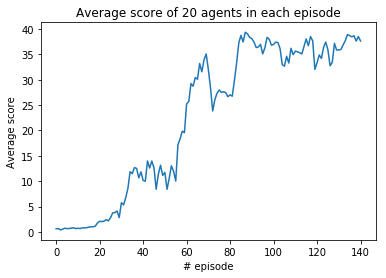

In [23]:
plt.plot(total_scores)
plt.title("Average score of 20 agents in each episode")
plt.xlabel("# episode")
plt.ylabel("Average score")

#### Agent Testing

In [24]:
actor_current.load_state_dict(torch.load('actor_current.pth'))
actor_network = actor_current

env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)

for t in range(max_t):
    sts = torch.tensor(states, dtype=torch.float, device=device)

    actor_network.eval()
    with torch.no_grad():
        actions = actor_network(sts).detach().cpu().numpy()
    actor_network.train()
    
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
        
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 37.39699916411191


When finished, you can close the environment.

In [ ]:
env.close()

### 4. Future work

1. Batchnorm layer is usually known to help the NN optimization, but it seemed to worsen the performnace with the given NN-architecture and task/environment. A few hypotheses can be explored with a detailed look at the training steps
    - The reward is quite big in this environment. With a simple NN-architecture heavily using BN, one signle output layer needs to deal with the big reward scale, which might not be appropriate
    - BN might not help much in RL setting where the input data has a very big variance. (considering the usual batch size of 32 ~ 256 time-steps)
    - NN is too small and simple. BN might not have a big impact in a small NN


2. In DDPG algorithm, the actor can be trained with a Q-value estimate of critic current or target network. It can be expected that the current encourages faster training and the target can help more stable training. This expectation can be tested with an experiment.


3. Other policy-gradient methods can be tried and compared against DDPG algorithm 